In [34]:
from sklearn.metrics import f1_score , precision_score , recall_score , accuracy_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


data = pd.read_csv('final_data/TrainFinal.csv', delimiter = ',').reset_index(drop=True)
data.shape

(49995, 625)

In [35]:
# data

In [36]:
category_list = [
 'Text_gnd_cd',
 'Text_th_flg',
 'Text_mar_st_cd',
 'Text_ocp_cd',
 'Text_idv_incm_seg_cd',
 'Text_fam_incm_seg_cd',
 'Text_IsAccAgeMoreThanCusAge',
 'Text_Mode_mbl_svc_opr'
]

In [37]:
for i in category_list:
    print(len(data[i].unique()),i)

2 Text_gnd_cd
2 Text_th_flg
4 Text_mar_st_cd
13 Text_ocp_cd
15 Text_idv_incm_seg_cd
7 Text_fam_incm_seg_cd
2 Text_IsAccAgeMoreThanCusAge
9 Text_Mode_mbl_svc_opr


In [38]:
data_ans = pd.read_csv('final_data/TestFinal.csv', delimiter = ',')
data_ans.shape

(49995, 619)

In [39]:
data[category_list] = data[category_list].fillna('none')
data_ans[category_list] = data_ans[category_list].fillna('none')
data = data.fillna(0)
data_ans = data_ans.fillna(0)
data[category_list] = data[category_list].astype('str')
data_ans[category_list] = data_ans[category_list].astype('str')

In [40]:
list_target = [
 'TargetEndIsLogIn',
 'TargetEndIsTrxInq',
 'TargetEndIsBillPayment',
 'TargetEndFundTR',
 'TargetEndORFT',
'TargetDayIsLogin',
 'TargetDayIsTrxInq',
 'TargetDayBillPayment',
 'TargetDayFundTR',
 'TargetDayORFT',
 
]

In [41]:
data_x = data.drop(list_target, axis=1)
x = data_x.copy()
feature_name = list(data_x)
# list_target = []
y = data[list_target]

In [42]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=0, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [43]:
x_ans = data_ans[list(x)]

In [44]:
df_combine=pd.concat([x,x_ans],ignore_index=True)
print(df_combine.shape)
#Find One_hot features that unique count <15
one_hot = df_combine[list(category_list)].nunique().reset_index()
one_hot.columns = ['features','unique_count']
one_hot = one_hot.loc[one_hot['unique_count'] < 16,"features"]
one_hot = list(one_hot)
one_hot

(99990, 615)


['Text_gnd_cd',
 'Text_th_flg',
 'Text_mar_st_cd',
 'Text_ocp_cd',
 'Text_idv_incm_seg_cd',
 'Text_fam_incm_seg_cd',
 'Text_IsAccAgeMoreThanCusAge',
 'Text_Mode_mbl_svc_opr']

In [45]:
for i in one_hot:
    category_list.remove(i)
for i in one_hot:
    print("Process feature =====>"+str(i))
    df_combine["one_hot_feature"] = df_combine[i]
    df_combine["one_hot_feature"] =  str(i) + "." + df_combine["one_hot_feature"].astype('str')
    one_hot_combine = pd.get_dummies(df_combine["one_hot_feature"])
    print(one_hot_combine.shape)
    df_combine = df_combine.join(one_hot_combine)
    del df_combine["one_hot_feature"]
    del df_combine[i]
    del one_hot_combine
    print(df_combine.shape)
x = df_combine[:len(x)]
print(x.shape)
x_ans = df_combine[len(x):]
print(x_ans.shape)
del df_combine

Process feature =====>Text_gnd_cd
(99990, 2)
(99990, 616)
Process feature =====>Text_th_flg
(99990, 2)
(99990, 617)
Process feature =====>Text_mar_st_cd
(99990, 4)
(99990, 620)
Process feature =====>Text_ocp_cd
(99990, 13)
(99990, 632)
Process feature =====>Text_idv_incm_seg_cd
(99990, 15)
(99990, 646)
Process feature =====>Text_fam_incm_seg_cd
(99990, 7)
(99990, 652)
Process feature =====>Text_IsAccAgeMoreThanCusAge
(99990, 2)
(99990, 653)
Process feature =====>Text_Mode_mbl_svc_opr
(99990, 9)
(99990, 661)
(49995, 661)
(49995, 661)


In [46]:
category_list

[]

In [190]:
# x.values[0,:]

In [152]:
print(x.shape,y.shape,x_ans.shape)

(49995, 635) (49995, 10) (49995, 635)


In [ ]:
from sklearn.model_selection import train_test_split
# x, x_stack, y, y_stack = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state=42)

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(x_train, label=y_train)
dx_val = xgb.DMatrix(x_val, label=y_test)
dy_val = xgb.DMatrix(y_val, label=y_train)
evallist = [(dv0, 'eval'), (dsm, 'train')]
                  
dsm = xgb.DMatrix(x_sm, label=y_sm)                  
evallist = [(dt, 'eval'), (dsm, 'train')]
                  
num_round = 10000
# binary:logistic
param = {'objective': 'binary:logistic',
 'colsample_bytree': 0.9683760122352089,
 'gamma': 0.7790711924812199,
 'learning_rate': 0.2249426498504554,
 'max_depth': 20,
 'min_child_weight': 10.95324500379702,
 'n_estimators': 150,
 'objective': 'binary:logistic',
 'scale_pos_weight': 1,
 'seed': 42,
 'eval_metric': ['auc'],
 'lambda': 2,
 'alpha': 15,
#  'rate_drop':0.5,
 'tree_method':'exact',
 'normalize_type':'forest',
 'subsample': 0.9035691355661921}
 
evals_result = {}


In [ ]:
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMRegressor
from sklearn.linear_model import ElasticNetCV

import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV


lgb_params = {"objective" : "binary", "metric" : "auc",
              "num_leaves" : 50, "learning_rate" : 0.032, 
              "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9, 'use_best_model':True}

k=1
splits=5
avg_score=0

# x_for_train = x_stack.copy()
# x_ans_train = x_ans_stack.copy()

x_for_train = pd.concat([x, x_stack], axis=1, sort=False)
x_ans_train = x_ans.reset_index(drop=True).join(x_ans_stack)
# x_ans_train = pd.concat([x_ans, x_ans_stack], axis=1, sort=False)

# x_for_train = x.copy() 
# x_ans_train = x_ans.copy()
# select_feature = list(x_for_train)
# select_feature = feature_name
x_for_train = x_for_train[select_feature]
x_ans_train = x_ans_train[select_feature]
x_f = x_for_train.values

skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=200)
skf.get_n_splits(x_f)
print('\nStarting KFold iterations...')
importances = pd.DataFrame()
# x_stack = x_for_train.copy()
# x_stack['y_lgb'] = 0

for train_index,test_index in skf.split(x_f,y_kf):

    model = LGBMClassifier(**lgb_params)
    df_X=x_f[train_index,:]
    df_y=y[train_index]
    val_X=x_f[test_index,:]
    val_y=y[test_index]
    
    model.fit(df_X,df_y)
    preds_x=pd.Series(model.predict(val_X))
#     acc= score1(val_y,preds_x)
    threshold , acc , preds_x = best_threshold(val_y,preds_x)
    print('Iteration:',k,'  rmse:',acc)
    
    if k==1:
        score=acc
        model1=model
        preds1=pd.Series(model.predict(x_ans_train.values))
        preds = preds1
        sv = preds.copy()
        
    else:
        preds1=pd.Series(model.predict(x_ans_train.values))
        preds=preds+preds1
        if score>acc:
            score=acc
            model1=model
            sv = preds1.copy()

            
    imp_df = pd.DataFrame()
    imp_df['feature'] = np.asarray(select_feature)
    imp_df['gain'] = model.feature_importances_
#     imp_df['gain'] = model.coef_
    imp_df['fold'] = k
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    avg_score=avg_score+acc        
    k=k+1
print('\n Best score:',score,' Avg Score:',avg_score/splits)
preds=preds/splits

In [ ]:



# sm = SMOTETomek(random_state=42)
# sm = ADASYN(random_state=42)
# sm.fit(x)
# x_sm, y_sm = sm.fit_sample(x_train, y_train)


print(x.shape,y.shape)

In [14]:
y.mean()

TargetEndIsLogIn          0.633203
TargetEndIsTrxInq         0.505491
TargetEndIsBillPayment    0.239064
TargetEndFundTR           0.395920
TargetEndORFT             0.037904
TargetDayIsLogin          0.676348
TargetDayIsTrxInq         0.561636
TargetDayBillPayment      0.281728
TargetDayFundTR           0.458726
TargetDayORFT             0.046445
dtype: float64

In [54]:
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.linear_model import ElasticNetCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN 
from imblearn.combine import SMOTEENN ,SMOTETomek
from xgboost import XGBClassifier
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression , ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA , NMF
from imblearn.under_sampling import ClusterCentroids, EditedNearestNeighbours , TomekLinks
# pca = PCA(n_components=n_components, svd_solver='full',random_state=42)
# pca = NMF(n_components=n_components, init='random',random_state=42)
# pca.fit(x)
# x = pca.transform(x)
# x_ans = pca.transform(x_ans)

test = 0
def train_predict(x_f,y_kf,x_ans_train,y_name,params,splits,skf):
    k=1
#     splits=5
    avg_score=0
    tres = 0
    x_ans_train = x_ans_train.values
#     scaler = preprocessing.MinMaxScaler()
#     scaler.fit(x_f)
#     x_f = scaler.transform(x_f)
#     x_ans_train = scaler.transform(x_ans_train)
#     sm = SMOTEENN(random_state=42)
#     sm = ADASYN(random_state=42)
#     x_f, y_kf = sm.fit_sample(x_f, y_kf)
#     x_train_pre = pd.DataFrame()
#     x_train_pre['y_lgb'] = np.zeros(x_f.shape[0])
    x_train_pre = pd.DataFrame({'x_pre':np.zeros(x_f.shape[0])})
    print('\nStarting KFold iterations... for : '+y_name)
    importances = pd.DataFrame()
    pca = PCA(n_components=150, svd_solver='full',random_state=42)
    pca.fit(x_f)
    x_f = pca.transform(x_f)
    x_ans_train = pca.transform(x_ans_train)
#         sm = SMOTEENN(random_state=42)
    for train_index,test_index in skf.split(x_f,y_kf):
#         model = XGBClassifier(**params)
        model = LGBMClassifier(**params)
#         model = ElasticNetCV(cv=5, random_state=0,l1_ratio=[0.05,.1,0.15,.2, .5, .9,0.95, 1],n_jobs=-1
#                                  ,normalize=False, positive=False)
        estimator = RandomForestClassifier()
        params = {
            "max_depth": [1, 2, 3,5,10,20,30,40,50,100, None],
            "max_features": st.randint(1, 300),
        #     "max_features": ["log2"],
            "min_samples_split": st.randint(2, 10),
        #     "min_samples_leaf": st.randint(1, n_features),
        #     "bootstrap": [True, False],
            "criterion": ["gini", "entropy"],
            'oob_score': [True, False],
            'random_state': [242],
            'warm_start' : [True],
        }
        rnf = RandomizedSearchCV(estimator, params, cv=5,n_jobs=-1, n_iter=10, scoring = 'roc_auc') 
#         model = rnf
#         print(train_index)
        df_X=x_f[train_index]
        df_y=y_kf[train_index]
        val_X=x_f[test_index]
        val_y=y_kf[test_index]
#         cc = ClusterCentroids(random_state=42)
#         enn = EditedNearestNeighbours()
#         df_X, df_y = enn.fit_sample(df_X, df_y)
        
#         sm = ADASYN(random_state=42)
#         sm = SMOTE(random_state=42,k_neighbors = 40,m_neighbors=40 ,n_jobs = -1)
#         df_X, df_y = sm.fit_sample(df_X, df_y)
        model.fit(df_X,df_y)
        preds_x=pd.Series(model.predict(val_X))
        threshold_i , acc , x_01_i = best_threshold(val_y,preds_x)
        print('Iteration:',k,'  acc:',acc)
        x_train_pre['x_pre'][test_index] = preds_x 
        if k==1:
            score=acc
            model1=model
            preds1=pd.Series(model.predict(x_ans_train))
            preds = preds1
#             sv = preds.copy()

        else:
            preds1=pd.Series(model.predict(x_ans_train))
            preds=preds+preds1
            if score>acc:
                score=acc
                model1=model
#                 sv = preds1.copy()


        imp_df = pd.DataFrame()
#         imp_df['feature'] = np.asarray(select_feature)
#         imp_df['gain'] = model.feature_importances_
#         imp_df['fold'] = k
#         importances = pd.concat([importances, imp_df], axis=0, sort=False)

        avg_score=avg_score+acc        
#         tres = tres + threshold
        k=k+1
    
    x_train_pre = x_train_pre.values
    tres , acc , x_01 = best_threshold(y_kf,x_train_pre)
    print('\n Best score:',score,' Avg Score:',avg_score/splits,' acc all:',acc)
#     tres = tres/splits
    preds=preds/splits
    preds = preds > tres
    preds = preds.astype(int)
    return preds , importances , x_train_pre

In [48]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , recall_score , accuracy_score , roc_curve , auc , classification_report,fbeta_score
def score1(y_true,y_pre,thresholds = 0.5):
    acc = accuracy_score(y_true, y_pre)
    return acc
def best_threshold(y_true,y_pre):
    thresholds = np.arange(0, 1, 0.005)
    best = 0.5
    acc = 0
    k = 0
    x_01 = y_pre
    for i in thresholds:
        y_pre_i  = y_pre > i
        y_pre_i = y_pre_i.astype(int)
        acc_i = score1(y_true,y_pre_i)
        if acc < acc_i:
            best = i
            acc = acc_i
            x_01 = y_pre_i
    return best , acc , x_01
#         print('test:',score1(val_y,test),", i = ",i)

In [49]:
# category_list.remove('Text_gnd_cd')

In [50]:
# list(x)

In [56]:
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.linear_model import ElasticNetCV
from xgboost import XGBClassifier

import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV
# x_for_train = x.copy() 
# x_ans_train = x_ans.copy()
# # select_feature = list(x_for_train)
# select_feature = feature_name
# x_for_train = x_for_train[select_feature]
# x_ans_train = x_ans_train[select_feature]
# x_f = x_for_train.values
test = 0
# skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=200)
# skf.get_n_splits(x_f)
feature_name = list(x)
# x_result = pd.DataFrame({'ini':np.zeros(x.shape[0])})
x_stack_list = pd.DataFrame({'ini':np.zeros(x.shape[0])})
x_ans_result = pd.DataFrame({'ini':np.zeros(x_ans.shape[0])})
# x_stack_list2 = pd.DataFrame({'ini':np.zeros(x.shape[0])})
# x_ans_result2 = pd.DataFrame({'ini':np.zeros(x_ans.shape[0])})

list_importances = []
# list_target = []

for i in list_target:
    splits=5
#     x_for_train = x.copy() 
#     x_ans_train = x_ans.copy()
    x_for_train = pd.concat([x, x_stack_list], axis=1, sort=False)
    x_ans_train = x_ans.reset_index(drop=True).join(x_ans_result)
    select_feature = list(x_for_train)
#     select_feature = feature_name
    x_for_train = x_for_train[select_feature]
    x_ans_train = x_ans_train[select_feature]
    
    for a in category_list:
        x_for_train[a], x_ans_train[a] = target_encode(x_for_train[a], 
                                 x_ans_train[a], 
                                 target=y[i], 
                                 min_samples_leaf=10,
                                 smoothing=5,
                                 noise_level=0,
                                      )

    y_kf = y[i].values
    x_f = x_for_train.values
#     print(x_for_train.values[0,:])
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=200)
    skf.get_n_splits(x_f)
   
    lgb_params = {"objective" : "binary", "metric" : "auc",
              "num_leaves" : 50, "learning_rate" : 0.032, 
              "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9, 'use_best_model':True ,'nthread':-1}

#     if(i == 'TargetEndIsLogIn'):
#         lgb_params = {"n_estimators":500, "objective" : "binary", "metric" : "auc",
#               "num_leaves" : 50, "learning_rate" : 0.032, 
#               "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9, 'use_best_model':True}
    preds , importances , x_stack = train_predict(x_f,y_kf,x_ans_train,i,lgb_params,splits,skf)
    list_importances = list_importances+[importances]
    x_stack_list[i] = x_stack
    x_ans_result[i] = preds
#     x_stack_list2[i] = x_stack
#     x_ans_result2[i] = preds
x_stack_list = x_stack_list.drop(['ini'],axis=1)
x_ans_result = x_ans_result.drop(['ini'],axis=1)
# x_stack_list2 = x_stack_list2.drop(['ini'],axis=1)
# x_ans_result2 = x_ans_result2.drop(['ini'],axis=1)


Starting KFold iterations... for : TargetEndIsLogIn


C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Iteration: 1   acc: 0.8524


C:\Users\EBM_IT_01\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


TypeError: Unknown type of parameter:max_features, got:rv_frozen

In [39]:
# x_stack_list

In [40]:
# pd.concat([x, x_stack_list], axis=1, sort=False)
# x_ans.reset_index(drop=True).join(x_ans_result)

In [59]:
# np.savetxt("final_submit/test03.csv", x_ans_result.values.astype(int), delimiter=",", fmt='%4d')
np.savetxt("final_submit/test03.csv", x_ans_result.values.astype(int), delimiter=",")

In [17]:
importances = list_importances[0]

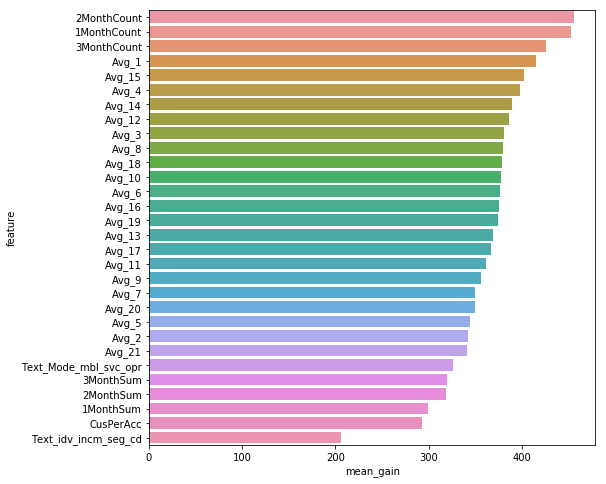

In [26]:
import warnings
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 8))
sns.barplot(x='mean_gain', y='feature', data=importances.sort_values('mean_gain', ascending=False).head(150))

In [292]:
# sns.barplot(x='mean_gain', y='feature', data=importances.sort_values('mean_gain', ascending=False))

In [33]:
select_feature = importances.sort_values('mean_gain', ascending=False).groupby('feature').mean()
select_feature = select_feature[select_feature['mean_gain'] > 50]
select_feature = select_feature.index.values.tolist()
# select_feature = np.hstack(select_feature.index.values,np.array(['y_lgb']))
len(select_feature)

138

In [ ]:
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.linear_model import ElasticNetCV
# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
# from xgboost import XGBRegressor
# from sklearn.neighbors import KNeighborsRegressor
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV
import classification

k=1
splits=5


lgb_params = {"objective" : "binary", "metric" : "auc",
              "num_leaves" : 50, "learning_rate" : 0.032, 
              "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9, 'use_best_model':True}


y_kf = np.copy(y)
y_kf[y_kf != 0] = 1

x_f = x.values
skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=200)
skf.get_n_splits(x_f)
print('\nStarting KFold iterations...')
importances = pd.DataFrame()

x_stack = pd.DataFrame({'ini':np.zeros(x.shape[0])})
x_ans_stack = pd.DataFrame({'ini':np.zeros(x_ans.shape[0])})

avg_score= np.zeros(6)
avg_score_all = 0
kk = 1
for train_index,test_index in skf.split(x_f,y_kf):

    lgb = LGBMRegressor(**lgb_params)
#     xgb = XGBRegressor(nthread=-1)

    
    df_X=x_f[train_index,:]
    df_y=y[train_index]
    val_X=x_f[test_index,:]
    val_y=y[test_index]
    
    modelq = classification.get_regressor(n_jobs = -1,n_iter = 5,n_iter_nt = 2,n_components = 25,cv = 5,
                  seed=42,n_features= 40,is_pca = False,scoring = 'neg_mean_absolute_error')
#     models = [('lgb',lgb),('xgb',xgb),('rnf',rnf)]
    models = [('lgb',lgb)] + modelq
    for n,(name,model) in enumerate(models,0):
        model.fit(df_X,df_y)
        preds_x=pd.Series(model.predict(val_X))
        acc = score1(val_y,preds_x)
        print('Iteration:',k,'  rmse:',acc,'  model:',name)
        if k==1:
            x_stack['y_'+name] = 0
            x_ans_stack['y_'+name] = 0
            
        if kk == 1:
            kk = kk+1;
            x_stack = x_stack.drop(['ini'],axis=1)
            x_ans_stack = x_ans_stack.drop(['ini'],axis=1)
        x_stack['y_'+name][test_index] = preds_x 
        preds1=pd.Series(model.predict(x_ans.values))
        
        x_ans_stack['y_'+name] += (preds1/splits)
        avg_score[n]=avg_score[n]+acc
    
    val_mean = np.mean(x_stack.values[test_index,:], axis=1)
    avg_score_all += score1(val_y,val_mean)/splits
    print('Iteration:',k,' (All models)   rmse:',score1(val_y,val_mean))
    k=k+1
print(' Avg Score:',avg_score/splits,"  All models:",avg_score_all)
# print('\n Best score:',score,' Avg Score:',avg_score/splits)
# preds=preds/splits
# x_ans_stack = x_ans.copy()
# x_ans_stack['y_lgb'] = 0
# x_ans_stack['y_lgb'] = preds

In [19]:
import numpy as np
np.savetxt("final_submit/test.csv", (np.zeros((49995,10))).astype(int), delimiter=",", fmt='% 4d')

In [16]:
(np.zeros((49995,10))+1).astype(int)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])